# LogGabor user guide


Table of content
----------------

* [What is the LogGabor package?](LogGabor.ipynb#What-is-the-LogGabor-package?) 

* [Installing](LogGabor.ipynb#Install) 

* [Importing the library](LogGabor.ipynb#Importing-the-library)

* [Properties of log-Gabor filters](LogGabor.ipynb#Properties-of-log-Gabor-filters)

* [Testing filter generation](LogGabor_testing-filter-generation.ipynb) 

* [Testing on a sample image](LogGabor.ipynb#Testing-on-a-sample-image) 

* [Building a pyramid](LogGabor_making-a-pyramid.ipynb) 

* [An example of fitting images with log-Gabor filters](LogGabor_fit-example.ipynb) 

## Importing the library

In [1]:
%load_ext autoreload
%autoreload 2
from LogGabor import LogGabor

parameterfile = (
    "https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py"
)
lg = LogGabor(parameterfile)
lg.set_size((32, 32))

To install the dependencies related to running this notebook, see [Installing notebook dependencies](#Installing-notebook-dependencies).

[Back to top](#LogGabor-user-guide)

In [2]:
import os
import numpy as np

np.set_printoptions(formatter={"float": "{: 0.3f}".format})
%matplotlib inline
import matplotlib.pyplot as plt

fig_width = 12
figsize = (fig_width, 0.618 * fig_width)

### Perspectives: Better fits of the filters

Basically, it is possible to infer the best possible log-Gabor function, even if it's parameters do not fall on the grid


Defining a reference log-gabor  (look in the corners!)

initial_guess : [15, 9, 0.26179938779914935, 0.12435117250106024] , idx : (15, 9, 13, 3)
popt : [ 14.619  8.855  0.212  0.102] , true :  14.6 8.5 0.20943951023931953 0.1


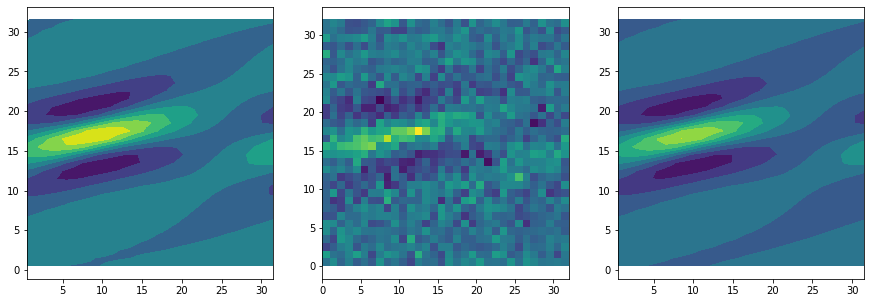

In [3]:
def twoD_Gaussian(xy, x_pos, y_pos, theta, sf_0):
    FT_lg = lg.loggabor(
        x_pos,
        y_pos,
        sf_0=np.absolute(sf_0),
        B_sf=lg.pe.B_sf,
        theta=theta,
        B_theta=lg.pe.B_theta,
    )
    return lg.invert(FT_lg).ravel()


# Create x and y indices
x = np.arange(lg.pe.N_X)
y = np.arange(lg.pe.N_Y)
x, y = xy = np.meshgrid(x, y)

# create data
x_pos, y_pos, theta, sf_0 = 14.6, 8.5, 12 * np.pi / 180.0, 0.1
data = twoD_Gaussian(xy, x_pos, y_pos, theta=theta, sf_0=sf_0)


# plot twoD_Gaussian data generated above
# plt.figure()
# plt.imshow(data.reshape(lg.pe.N_X, lg.pe.N_Y))
# plt.colorbar()

# add some noise to the data and try to fit the data generated beforehand
data /= np.abs(data).max()
data_noisy = data + 0.25 * np.random.normal(size=data.shape)
# getting best match
C = lg.linear_pyramid(data_noisy.reshape(lg.pe.N_X, lg.pe.N_Y))
idx = lg.argmax(C)
initial_guess = [idx[0], idx[1], lg.theta[idx[2]], lg.sf_0[idx[3]]]
print("initial_guess :", initial_guess, ", idx :", idx)

import scipy.optimize as opt

popt, pcov = opt.curve_fit(twoD_Gaussian, xy, data_noisy, p0=initial_guess)

data_fitted = twoD_Gaussian(xy, *popt)

extent = (0, lg.pe.N_X, 0, lg.pe.N_Y)
print("popt :", popt, ", true : ", x_pos, y_pos, theta, sf_0)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
_ = axs[0].contourf(
    data.reshape(lg.pe.N_X, lg.pe.N_Y),
    8,
    extent=extent,
    cmap=plt.cm.viridis,
    origin="upper",
)
_ = axs[1].imshow(
    data_noisy.reshape(lg.pe.N_X, lg.pe.N_Y), cmap=plt.cm.viridis, extent=extent
)
_ = axs[2].contourf(
    data_fitted.reshape(lg.pe.N_X, lg.pe.N_Y),
    8,
    extent=extent,
    cmap=plt.cm.viridis,
    origin="upper",
)
for ax in axs:
    ax.axis("equal")

[Back to top](#LogGabor-user-guide)

## performing a fit

In [4]:
from LogGabor import LogGaborFit

lg = LogGaborFit(parameterfile)
lg.set_size((32, 32))

x_pos, y_pos, theta, sf_0 = 14.6, 8.5, 12 * np.pi / 180.0, 0.1
data = lg.invert(
    lg.loggabor(
        x_pos,
        y_pos,
        sf_0=np.absolute(sf_0),
        B_sf=lg.pe.B_sf,
        theta=theta,
        B_theta=lg.pe.B_theta,
    )
)
data /= np.abs(data).max()
data_noisy = data + 0.25 * np.random.normal(size=data.shape)


data_fitted, params = lg.LogGaborFit(data_noisy.reshape(lg.pe.N_X, lg.pe.N_Y))

In [5]:
data_fitted.shape

(32, 32)

In [6]:
params.pretty_print()

Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
B_sf       0.3755    0.001      inf  0.01536     True     None     None
B_theta    0.1684    0.001      inf 0.007364     True     None     None
phase     -0.2989     -inf      inf   0.1059     True     None     None
sf_0       0.1011    0.001      inf 0.001795     True     None     None
theta      0.2045   -1.571    1.571 0.005312     True     None     None
x_pos       14.31        0       32   0.1593     True     None     None
y_pos       7.726        0       32   0.2705     True     None     None


params : Parameters([('x_pos', <Parameter 'x_pos', value=14.305894604633949 +/- 0.159, bounds=[0:32]>), ('y_pos', <Parameter 'y_pos', value=7.725755384263746 +/- 0.271, bounds=[0:32]>), ('theta', <Parameter 'theta', value=0.20451580315562445 +/- 0.00531, bounds=[-1.5707963267948966:1.5707963267948966]>), ('sf_0', <Parameter 'sf_0', value=0.10113895438265275 +/- 0.00179, bounds=[0.001:inf]>), ('phase', <Parameter 'phase', value=-0.29890845891507284 +/- 0.106, bounds=[-inf:inf]>), ('B_sf', <Parameter 'B_sf', value=0.37545690182138414 +/- 0.0154, bounds=[0.001:inf]>), ('B_theta', <Parameter 'B_theta', value=0.16840243094402985 +/- 0.00736, bounds=[0.001:inf]>)]) , true :  14.6 8.5 0.20943951023931953 0.1


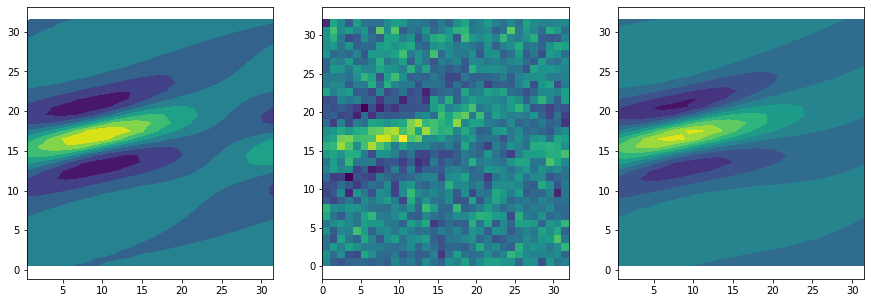

In [7]:
extent = (0, lg.pe.N_X, 0, lg.pe.N_Y)
print("params :", params, ", true : ", x_pos, y_pos, theta, sf_0)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
_ = axs[0].contourf(
    data.reshape(lg.pe.N_X, lg.pe.N_Y),
    8,
    extent=extent,
    cmap=plt.cm.viridis,
    origin="upper",
)
_ = axs[1].imshow(
    data_noisy.reshape(lg.pe.N_X, lg.pe.N_Y), cmap=plt.cm.viridis, extent=extent
)
_ = axs[2].contourf(
    data_fitted.reshape(lg.pe.N_X, lg.pe.N_Y),
    8,
    extent=extent,
    cmap=plt.cm.viridis,
    origin="upper",
)
for ax in axs:
    ax.axis("equal")

With periodic boundaries, check that the filter "re-enters" the image from  the other border:

params : Parameters([('x_pos', <Parameter 'x_pos', value=14.305893862225966 +/- 0.159, bounds=[0:32]>), ('y_pos', <Parameter 'y_pos', value=7.725755287883015 +/- 0.271, bounds=[0:32]>), ('theta', <Parameter 'theta', value=0.20451580451903784 +/- 0.00531, bounds=[-1.5707963267948966:1.5707963267948966]>), ('sf_0', <Parameter 'sf_0', value=0.10113895477158497 +/- 0.00179, bounds=[0.001:inf]>), ('phase', <Parameter 'phase', value=-0.29890899924549347 +/- 0.106, bounds=[-inf:inf]>), ('B_sf', <Parameter 'B_sf', value=0.37545689608736066 +/- 0.0154, bounds=[0.001:inf]>), ('B_theta', <Parameter 'B_theta', value=0.16840243358123808 +/- 0.00736, bounds=[0.001:inf]>)]) , true :  14.6 8.5 0.20943951023931953 0.1


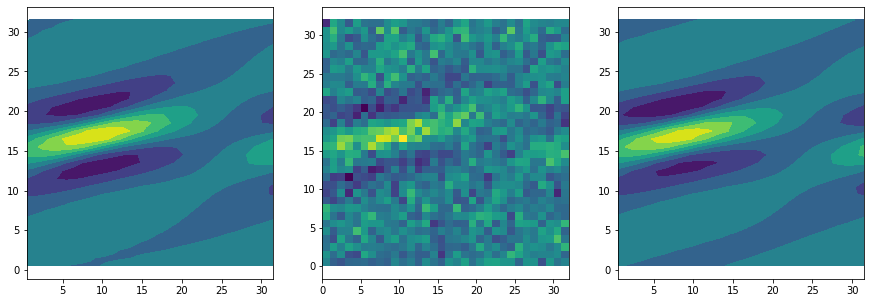

In [8]:
data_fitted, params = lg.LogGaborFit(
    data_noisy.reshape(lg.pe.N_X, lg.pe.N_Y), do_border=False
)
extent = (0, lg.pe.N_X, 0, lg.pe.N_Y)
print("params :", params, ", true : ", x_pos, y_pos, theta, sf_0)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
_ = axs[0].contourf(
    data.reshape(lg.pe.N_X, lg.pe.N_Y),
    8,
    extent=extent,
    cmap=plt.cm.viridis,
    origin="upper",
)
_ = axs[1].imshow(
    data_noisy.reshape(lg.pe.N_X, lg.pe.N_Y), cmap=plt.cm.viridis, extent=extent
)
_ = axs[2].contourf(
    data_fitted.reshape(lg.pe.N_X, lg.pe.N_Y),
    8,
    extent=extent,
    cmap=plt.cm.viridis,
    origin="upper",
)
for ax in axs:
    ax.axis("equal")

[Back to top](#LogGabor-user-guide)

## TODO: validation of fits

[Back to top](#LogGabor-user-guide)

## more book keeping

In [11]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,scipy,imageio,SLIP,LogGabor  -r -g -b

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-09-08T16:56:12+02:00

CPython 3.8.5
IPython 7.16.1

numpy 1.20.0.dev0+7d04e22
matplotlib 3.2.2
scipy 1.5.2
imageio 2.9.0
SLIP 20191113
LogGabor 20191113

compiler   : Clang 11.0.3 (clang-1103.0.32.62)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit
host name  : fortytwo
Git hash   : 8610d956aee6574a83ae83666bd5d8ebbd88a273
Git repo   : https://github.com/bicv/LogGabor
Git branch : master


[Back to top](#LogGabor-user-guide)
[Back to the LogGabor user guide](LogGabor.ipynb#LogGabor-user-guide)